In [20]:
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt
from algos import *
from infect import infect
from sbm import SBM

In [22]:
def iter(N, M, q0, q1, p0, p1, time_steps, num_sims, method, dataset='sbm', fraction_plp_in_clc=None):

    name = dataset+'N'+str(N)+'_M'+str(M)+'_SIM'+str(num_sims)+'_step'+str(time_steps)+'_q0'+str(q0)+'_q1'+str(q1)+'_p0'+str(p0)+'_p1'+str(p1)+method+'graphs.pkl'
    if not os.path.isfile(name):
        print('Generating synthetic dataset!')
        Gs = np.zeros((num_sims,N,N))
        Communities = dict()
        data = dict()
        Individuals = dict()
        if dataset=='sbm':
            for i in range(num_sims):
                Gs[i], communities = SBM(N, M, q0, q1)
                ###################################################
                communities = []
                approx_block_size = N // M
                for j in range(M):
                    community = list(range(j * approx_block_size, (j + 1) * approx_block_size))
                    communities.append(community)
                ###################################################
                Communities[i] = communities
                Individuals[i] = infect(Gs[i],p0,p1,time_steps)
        elif dataset=='iid':
            for i in range(num_sims):
                ###################################################
                '''your code here'''
                individuals = np.array([1 if np.random.rand() < p0 else 0 for _ in range(N)])
                Communities[i] = [list(range(N))]
                Individuals[i] = individuals
                ###################################################
        data['graph'] = Gs
        data['communities'] = Communities
        data['individuals'] = Individuals
        with open(name, 'wb') as infile:
            pickle.dump(data,infile) 
            print('Data loaded!')


    ###################################################
    '''your code for initialization parameters if needed''' 
    fraction_ppl = 0
    fraction_family = 0
    fraction_ppl_in_family = 0
    num_tests = np.zeros(6)
    num_stages = np.zeros(6)
    ###################################################
        
    if os.path.isfile(name):
        with open(name, 'rb') as infile:
            data = pickle.load(infile) 
        print('Data loaded!')
    for i in range(num_sims):
        if dataset=='synthetic':
            G = data['graph'][i]
            communities = data['communities'][i]
            individuals = data['individuals'][i]
        ###################################################
        '''your code to calculate the statistics here''' 
        infected_individuals = sum(individuals)
        fraction_ppl += infected_individuals / N
        infected_communities = sum([sum(individuals[community]) > 0 for community in communities])
        fraction_clc += infected_communities / len(communities)
        fraction_plp_in_clc += np.mean([sum(individuals[community]) / len(community) for community in communities])

        ###################################################

        # interleave the individuals
        s = individuals.copy()
        np.random.shuffle(s)
        
        numtests_bs, num_stages_bs, _ = binary_splitting(s)
        numtests_q1, num_stages_q1 = Qtesting1(s)
        numtests_q2, num_stages_q2 = Qtesting2(s)
        numtests_q1_c, num_stages_q1_c = Qtesting1_comm_aware(individuals.copy(), communities)
        numtests_q2_c, num_stages_q2_c = Qtesting2_comm_aware(individuals.copy(), communities)

        num_tests[0] += numtests_bs
        num_stages[0] += num_stages_bs
        num_tests[2] += numtests_q1
        num_stages[2] += num_stages_q1
        num_tests[3] += numtests_q2
        num_stages[3] += num_stages_q2
        num_tests[4] += numtests_q1_c
        num_stages[4] += num_stages_q1_c
        num_tests[5] += numtests_q2_c
        num_stages[5] += num_stages_q2_c

    fraction_ppl /= num_sims
    fraction_clc /= num_sims
    fraction_plp_in_clc /= num_sims
    num_tests /= num_sims
    num_stages /= num_sims

    return fraction_ppl, fraction_clc, fraction_plp_in_clc, num_tests, num_stages

<div class="alert alert-warning">
<b>Task 1 </b> 
Plot how the fraction of infected people, the percentage of infected communities, and the average percentage of infected people in each community change with the each setting for the synthetic dataset described in the following table and comment on the results. Average over at least $100$ SBM network realization.     

</div>

| N | M | q0, q1 | p0 | p1 |time steps  |
|---|---|--------|----|----|------------|
|256| 16| (1,0)  |0.001|[0.05:1]|2|
|   | 16|(0.9, 0.1)  | 0.001| [0.05:1]|2     |
|   | 16 |(0.5, 0.2)  | 0.001| [0.05:1]|2     |

Consider $N=256$, and $M=16,64,128$. Use SBM with $q0=1$ and $q1=0$ to generate contact networks (disconnected cliques). For the infection model, use $p_0 = 0.001$ and $p_1 = [0.01:1]$ and the number of infection steps as $2$ . 
Average over 100 SBM network realizations.

<div class="alert alert-warning">
<b>Task 2 </b> 
Provide plots for i.i.d. infection probability that ranges from $p=0.01$ to $p=0.3$, and $N=256$.
Compare the performance of tests $T_1$, $T_2$, and binary output tests. Do you observe a consistent performance? Can you explain your results? 
    
</div>

<div class="alert alert-warning">
<b>Task 3 </b>  
Provide plots that compare the performance of various testing techniques on the Stochastic Block Model (SBM) using the settings outlined in Table 2 and on real data. You may explore additional settings that could reveal significant insights for your custom algorithms. Interpret and explain the results you obtain. Your plots should include: (i) a plot demonstrating how the performance of different testing schemes varies as the family sizes change, (ii)a plot demonstrating how the performance of different testing schemes varies as the infection probability changes and (iii) a plot illustrating how infections concentrate within families in the SBM.
</div>

| N | M | q0, q1 | p0 | p1 |time steps  |
|---|---|--------|----|----|------------|
|256| 16| (0.9,0.1)  |0.001|[0.05:1]|2|
|   | 64|(1, 0)  | 0.001| [0.05:1]|2     |
|   | 64|(0.9, 0.1)  | 0.001| [0.05:1]|2     |
|   | 64|(0.5, 0.2)  | 0.001| [0.05:1]|2     |
|   | 128 |(0.9, 0.1)  | 0.001| [0.05:1]|2     |


In [23]:
N = 256
M = 16
q0 = 0.5
q1 = 0.3

time_steps = 2
method = 'your method'

In [28]:
# the simulation 
t = 10
fraction_infected_ppl = np.zeros(t)
fraction_infected_clc = np.zeros(t)
fraction_infected_family = np.zeros(t)
num_tests = np.zeros((t, 6))
num_stages = np.zeros((t, 6))
p0 = 0.001
num_sims = 100
for j in range(1, t + 1):
    p1 = j / t
    fraction_ppl, fraction_clc, fraction_plp_in_clc, tests, stages = iter(N, M, q0, q1, p0, p1, time_steps, num_sims, method, dataset='sbm')
    fraction_infected_ppl[j - 1] = fraction_ppl
    fraction_infected_clc[j - 1] = fraction_clc
    fraction_infected_family[j - 1] = fraction_plp_in_clc
    num_tests[j - 1] = tests
    num_stages[j - 1] = stages
       

Generating synthetic dataset!


ValueError: too many values to unpack (expected 2)

In [29]:
p1s = np.arange(1, t + 1) / t

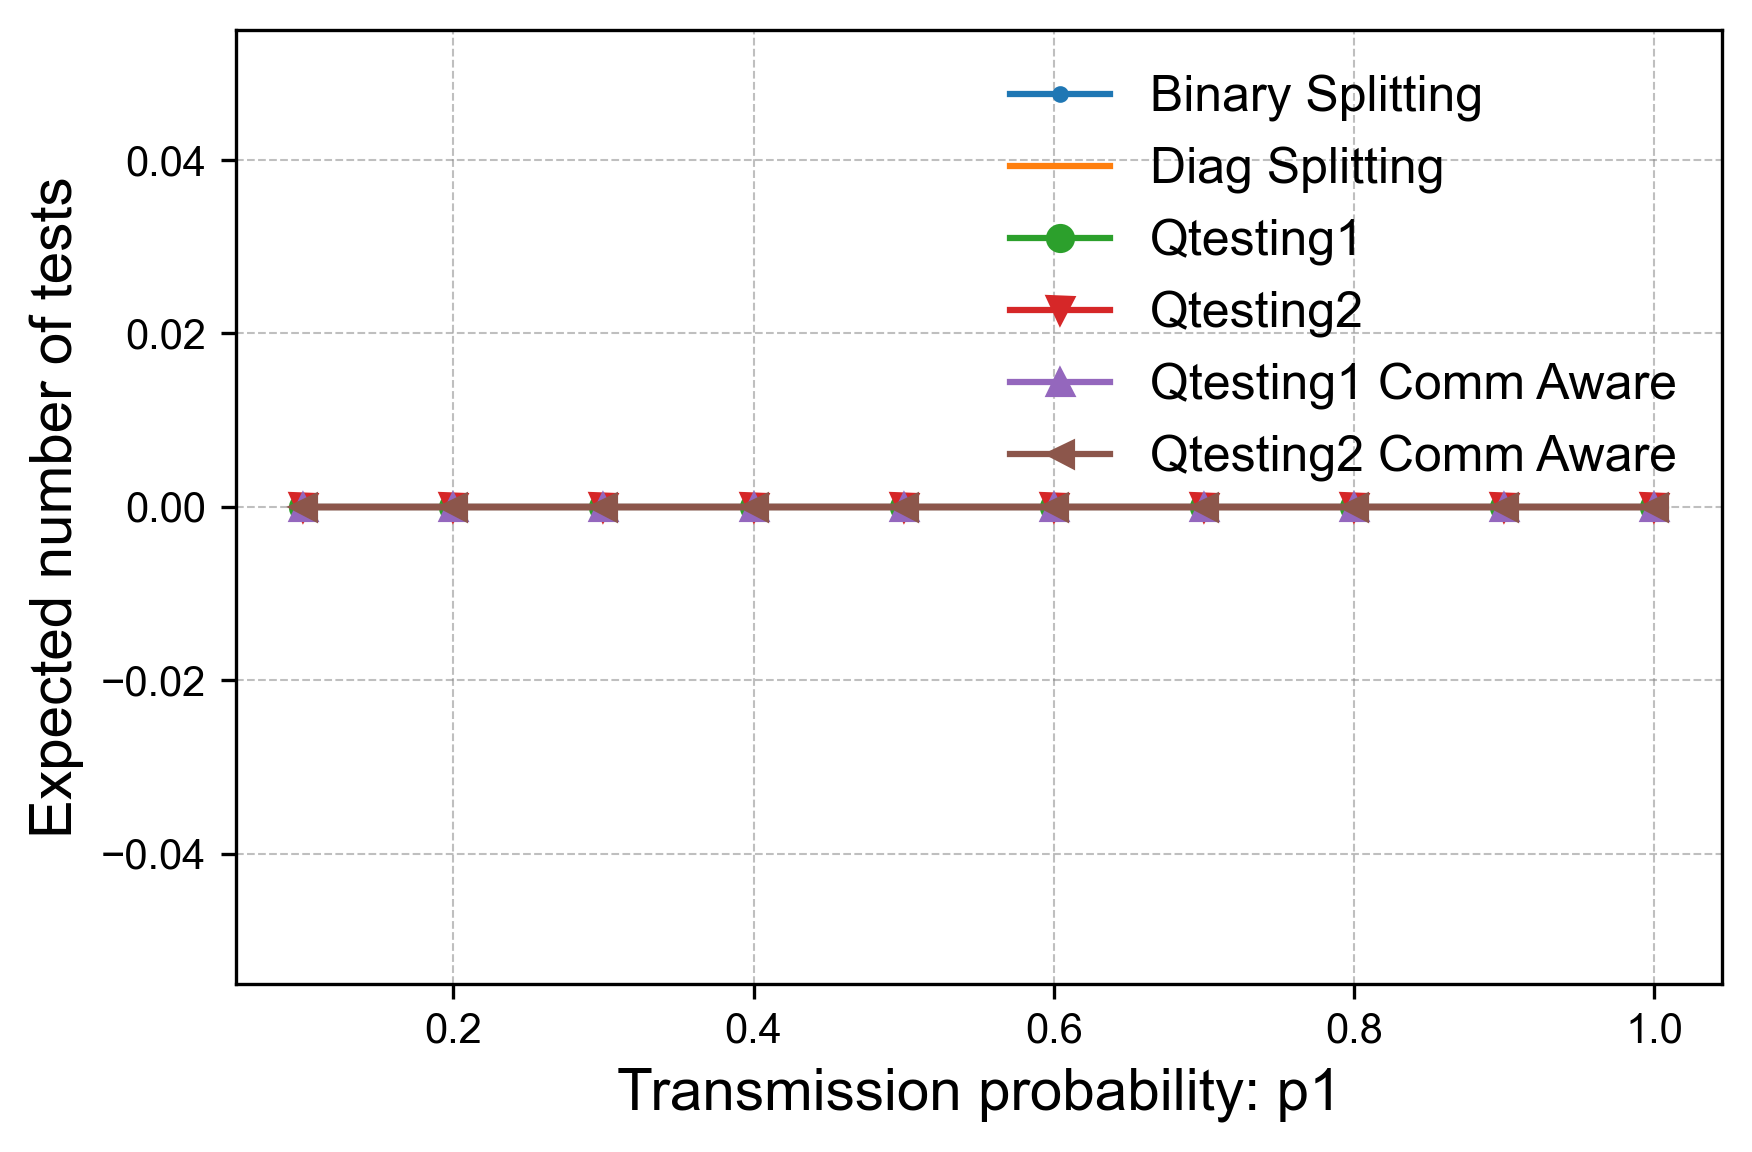

In [30]:
plt.figure(figsize=(6, 4), dpi=300)
plt.rcParams.update({
    'font.size': 12,
    'font.family': 'sans-serif',
    'font.sans-serif': 'Arial',
    'axes.labelsize': 12,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10
})
markers = ['.', ',','o','v','^','<','>']
labels = ['Binary Splitting', 'Diag Splitting', 'Qtesting1', 'Qtesting2', 'Qtesting1 Comm Aware', 'Qtesting2 Comm Aware']   
for i in range(6):
    plt.plot(p1s, num_tests[:, i], label=labels[i], marker=markers[i])
#########your code here###########

plt.xlabel('Transmission probability: p1', fontsize=14)
plt.ylabel('Expected number of tests', fontsize=14)
plt.legend()
plt.grid(True, linestyle='--', linewidth=0.5, color='gray', alpha=0.5)
plt.legend(frameon=False, loc='best')
plt.tight_layout()
fig_name = 'RES_N' + str(N) + '_M' + str(M) + 'SIM' + str(num_sims) + 'step_' + str(time_steps) + 'q0' + str(q0) + 'q1' + str(q1) + 'p0' + str(p0) + method + 'GT.pdf'
plt.savefig(fig_name, format='pdf', bbox_inches='tight')

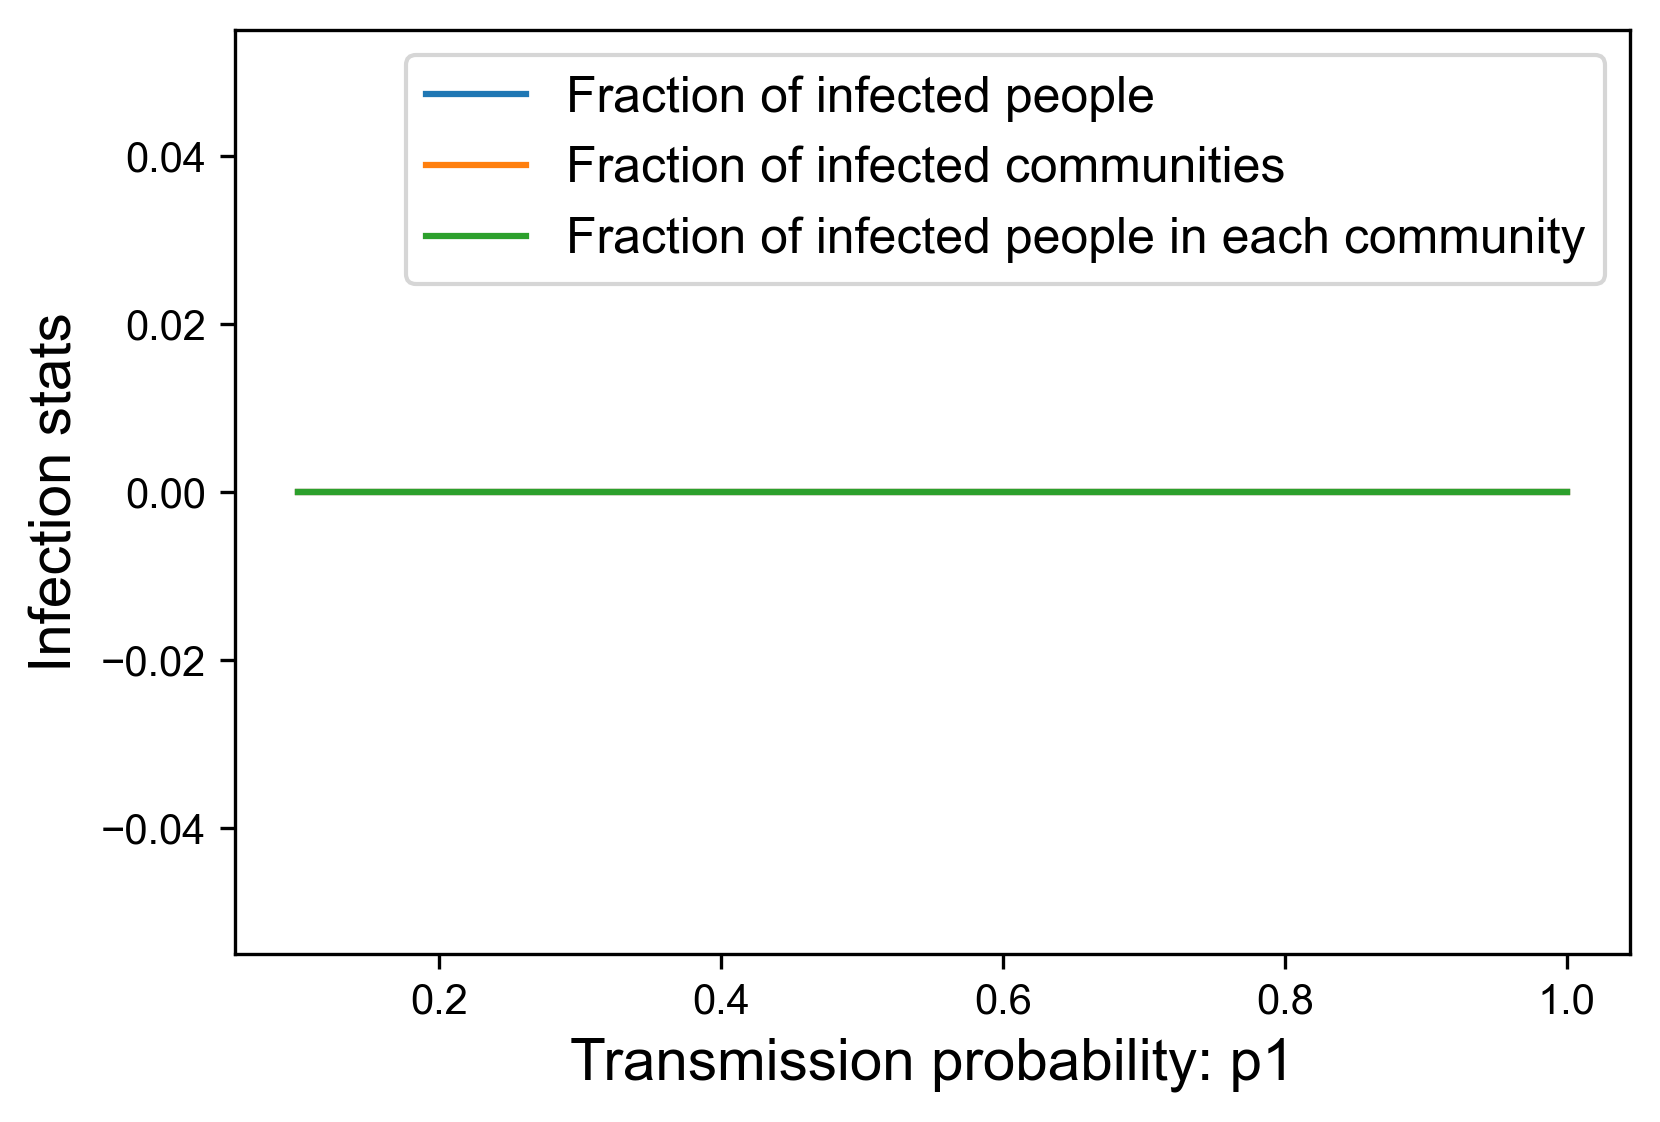

In [31]:
plt.figure(figsize=(6, 4), dpi=300)
plt.plot(p1s, fraction_infected_ppl, label='Fraction of infected people')
plt.plot(p1s, fraction_infected_clc, label='Fraction of infected communities')
plt.plot(p1s, fraction_infected_family, label='Fraction of infected people in each community')
plt.xlabel('Transmission probability: p1', fontsize=14)
plt.ylabel('Infection stats', fontsize=14)
plt.legend()
plt.savefig('RES_N' + str(N) + '_M' + str(M) + 'SIM' + str(num_sims) + 'step_' + str(time_steps) + 'q0' + str(q0) + 'q1' + str(q1) + 'p0' + str(p0) + method + 'stats.pdf')